In [1]:
!python --version

Python 3.7.16


In [1]:
import helpers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
# from activity.ActingAgent import Agent
import torch

In [2]:
envs = helpers.create_envs(yamls_filename='identical_region_yamls', n=10, num_discrete_action_levels=5)
agents_with_negotiation = helpers.create_agents(envs[0])
# agents_no_negotiation = helpers.create_agents(envs[0])

In [ ]:
# a, b = helpers.train(agents_no_negotiation, envs, epochs=100, batch_size=50, with_comm=False)
c, d = helpers.train(agents_with_negotiation, envs, epochs=50, batch_size=50, with_comm=True)

 46%|██████████████████▍                     | 23/50 [56:32<1:04:46, 143.94s/it]

In [6]:
helpers.eval_agents_det(agents_with_negotiation, envs[0])

array([0.06499822, 0.06472862])

In [17]:
c_extra, d_extra = helpers.train(agents_with_negotiation, envs, epochs=100, batch_size=50, with_comm=True)

100%|███████████████████████████████████████| 100/100 [1:15:50<00:00, 45.50s/it]


In [22]:
c_x, d_x = helpers.train(agents_with_negotiation, envs, epochs=100, batch_size=50, with_comm=True)

100%|███████████████████████████████████████| 100/100 [1:34:14<00:00, 56.55s/it]


In [24]:
#cc = np.concatenate((cc, c_x))
dd = np.concatenate((dd, d_x))

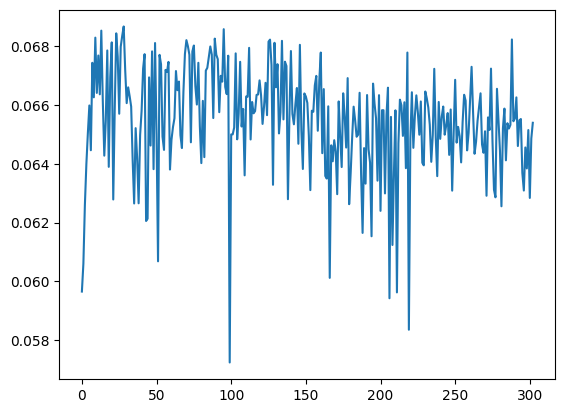

In [28]:
sns.lineplot(x = np.arange(len(dd)), y = dd[:, 0])
plt.show()

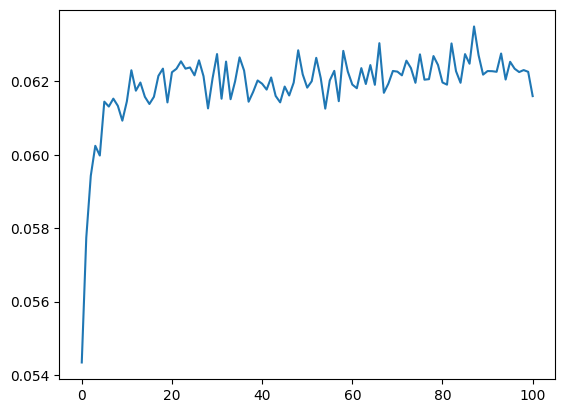

In [6]:
sns.lineplot(x = np.arange(len(a)), y = a[:, 0])
plt.show()

In [8]:
helpers.eval_deterministic(agents_no_negotiation, envs[0])

array([0.06783773, 0.06868256])

In [11]:
agents_no_negotiation = helpers.create_agents(envs[0])
a, b = helpers.train_no_comm(agents_no_negotiation, envs)

100%|███████████████████████████████████████████| 50/50 [17:47<00:00, 21.36s/it]


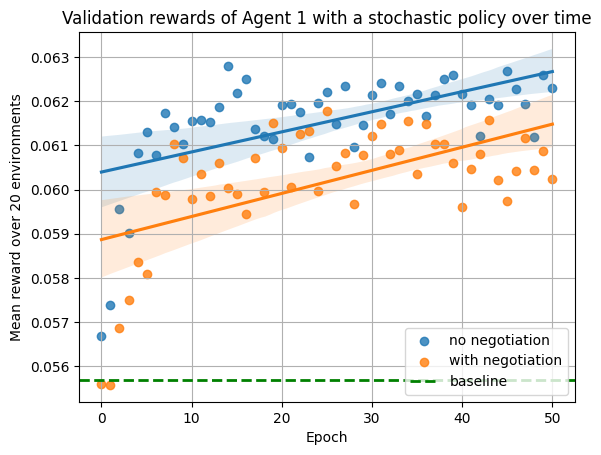

In [19]:
sns.regplot(x = np.arange(len(d)), y = a[:, 1], label='no negotiation')
sns.regplot(x = np.arange(len(b)), y = c[:, 1], label='with negotiation')
plt.title('Validation rewards of Agent 1 with a stochastic policy over time')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Mean reward over 20 environments')
plt.axhline(means.mean(), linestyle = '--', label = 'baseline', c = 'g', linewidth = 2)
plt.legend()
plt.savefig('stoch.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

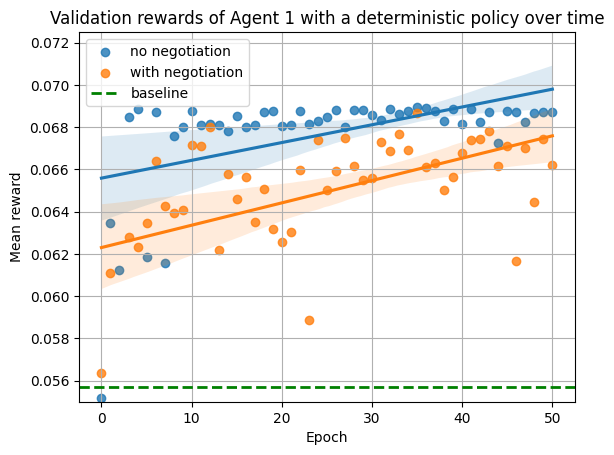

In [21]:
sns.regplot(x = np.arange(len(d)), y = b[:, 1], label='no negotiation')
sns.regplot(x = np.arange(len(b)), y = d[:, 1], label='with negotiation')
plt.title('Validation rewards of Agent 1 with a deterministic policy over time')
plt.axhline(means.mean(), linestyle = '--', label = 'baseline', c = 'g', linewidth = 2)
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean reward')
plt.ylim(.055, .0725)
plt.savefig('det.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

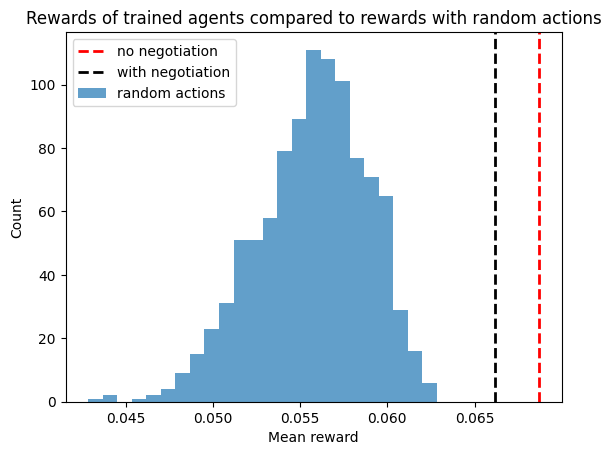

In [14]:
sns.histplot(means, alpha = .7, edgecolor = None, label = 'random actions')
#plt.xticks(ticks = np.arange(.0, .09, .01))
plt.axvline(b[:, 1][-1], c = 'red', linestyle = '--', linewidth = 2, label = 'no negotiation')
plt.axvline(d[:, 1][-1], c = 'black', linestyle = '--', linewidth = 2, label = 'with negotiation')
plt.legend()
plt.xlabel('Mean reward')
plt.title('Rewards of trained agents compared to rewards with random actions')
plt.savefig('comp.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

In [61]:
b[:, 1][-1]

0.0686483884230256

In [22]:
helpers.eval_agents_with_comm_deterministic(agents, envs[0])

array([0.06644271, 0.06539535])

In [24]:
helpers.eval_deterministic(agents_no_negotiation, envs[0])

array([0.06795761, 0.06854272])

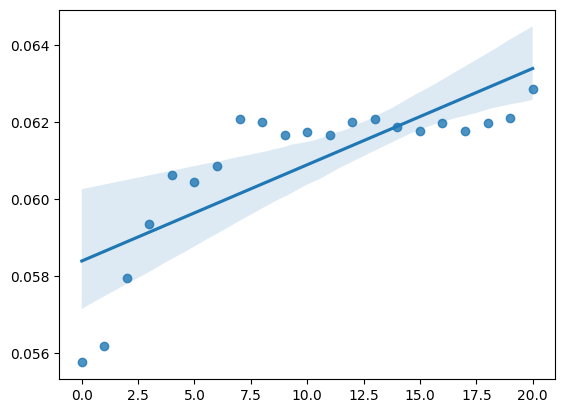

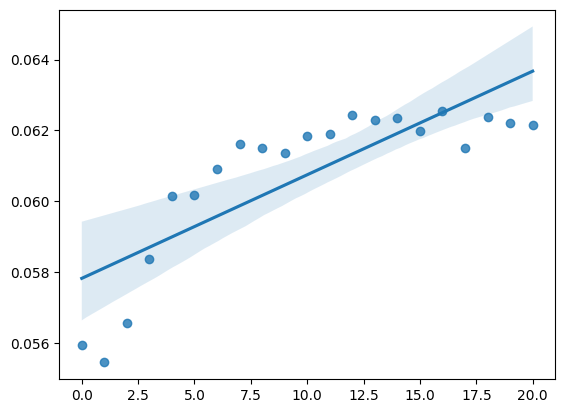

In [4]:
sns.regplot(x = np.arange(len(a)), y = a[:, 0])
plt.show()
sns.regplot(x = np.arange(len(a)), y = a[:, 1])
plt.show()

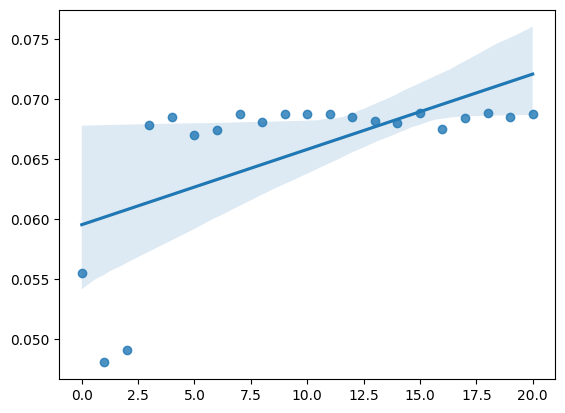

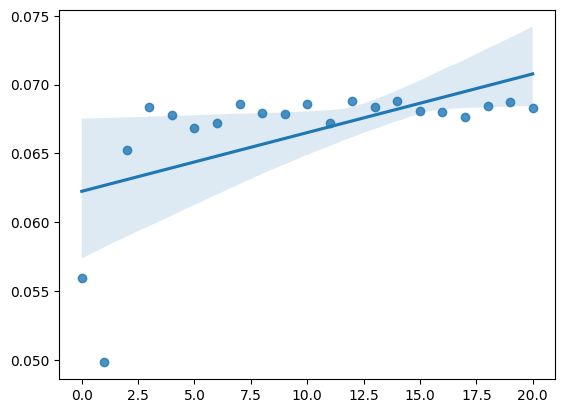

In [5]:
sns.regplot(x = np.arange(len(b)), y = b[:, 0])
plt.show()
sns.regplot(x = np.arange(len(b)), y = b[:, 1])
plt.show()

In [3]:
epochs = 100
batch_size = 20
episode_length = envs[0].episode_length
eval_rewards = np.zeros((epochs + 1, len(agents)))
eval_rewards[0] = helpers.eval_agents(agents, envs[0], False, n_trials=100)

for epoch in tqdm(range(epochs)):
    for batch in range(batch_size):
        states = [env.reset() for env in envs]
        
        for t in range(episode_length):
            actions = [
                agents[agent_id].act([state[agent_id] for state in states]) 
                for agent_id in range(len(agents))
            ]

            actions = [
                {
                    agent_id : actions[agent_id][env_id]
                    for agent_id in range(len(agents))
                }
                for env_id in range(len(envs))
            ]

            states, rewards, _, _ = zip(*[env.step(actions[i]) for (i, env) in enumerate(envs)])
            rewards = np.array([list(reward.values()) for reward in rewards])
            
            for i, agent in enumerate(agents):
                for env_id in range(len(envs)):
                    agent.ppo.buffer.rewards[env_id].append(rewards[env_id, i])
                    agent.ppo.buffer.is_terminals[env_id].append(t == episode_length - 1)
    for agent in agents:
        agent.update()

    eval_rewards[epoch + 1] = helpers.eval_agents(agents, envs[0], False, n_trials=100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:29<00:00, 17.69s/it]


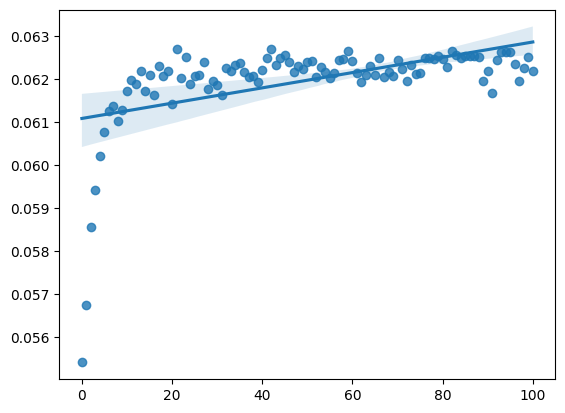

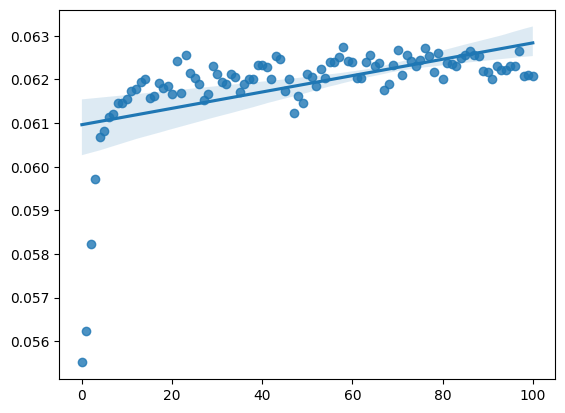

In [5]:
sns.regplot(x = np.arange(len(eval_rewards)), y = eval_rewards[:, 0])
plt.show()
sns.regplot(x = np.arange(len(eval_rewards)), y = eval_rewards[:, 1])
plt.show()

In [6]:
helpers.eval_deterministic(agents, envs[0], communication_on=False)

array([0.06165761, 0.0606377 ], dtype=float32)

In [3]:
a = helpers.train(agents, envs, epochs = 100, batch_size=20, communication_on=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:49<00:00,  8.29s/it]


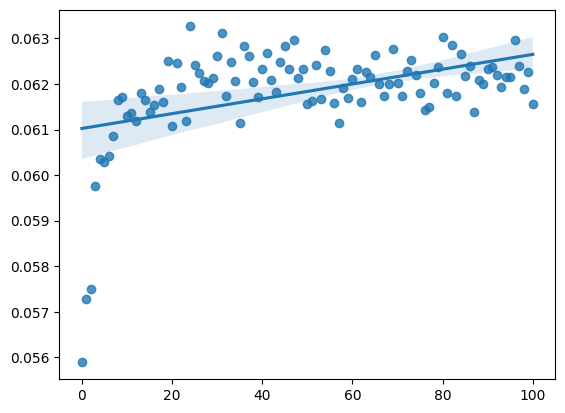

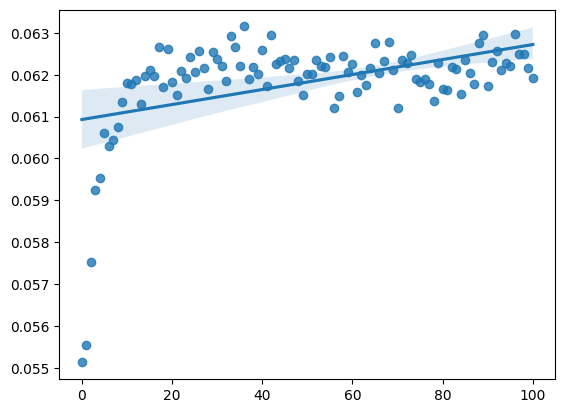

In [4]:
sns.regplot(x = np.arange(len(a)), y = a[:, 0])
plt.show()
sns.regplot(x = np.arange(len(a)), y = a[:, 1])
plt.show()

In [5]:
agents_no_negotiation = helpers.create_agents(envs[0])
b = helpers.train(agents_no_negotiation, envs, epochs = 70, batch_size=60, communication_on=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:19<00:00,  8.00s/it]


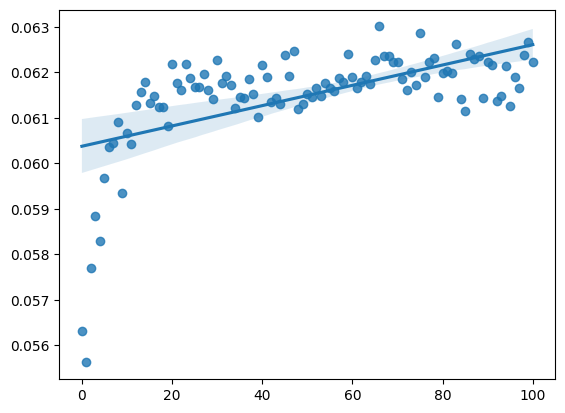

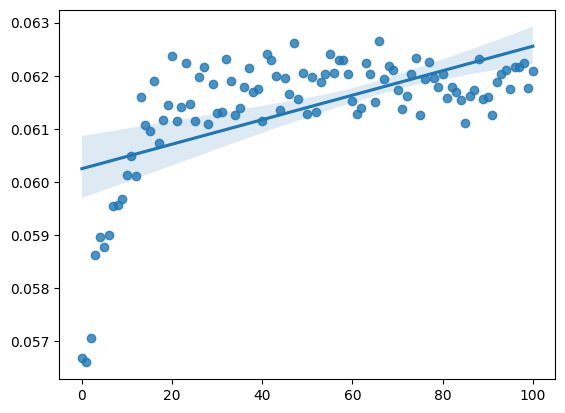

In [6]:
sns.regplot(x = np.arange(len(b)), y = b[:, 1])
plt.show()
sns.regplot(x = np.arange(len(b)), y = b[:, 0])
plt.show()

In [ ]:
epochs = 20
batch_size = 20
episode_length = envs[0].episode_length
eval_rewards = np.zeros((epochs + 1, len(agents)))
eval_rewards[0] = helpers.eval_agents(agents, envs[0], False)

for epoch in tqdm(range(epochs)):
    for batch in range(batch_size):
        states = [env.reset() for env in envs]
        
        for t in range(episode_length):
            actions = [
                agents[agent_id].act([state[agent_id] for state in states]) 
                for agent_id in range(len(agents))
            ]

            actions = [
                {
                    agent_id : actions[agent_id][env_id]
                    for agent_id in range(len(agents))
                }
                for env_id in range(len(envs))
            ]

            states, rewards, _, _ = zip(*[env.step(actions[i]) for (i, env) in enumerate(envs)])
            rewards = np.array([list(reward.values()) for reward in rewards])
            
            for i, agent in enumerate(agents):
                for env_id in range(len(envs)):
                    agent.ppo.buffer.rewards[env_id].append(rewards[env_id, i])
                    agent.ppo.buffer.is_terminals[env_id].append(t == episode_length - 1)
    for agent in agents:
        agent.update()

    eval_rewards[epoch + 1] = helpers.eval_agents(agents, envs[0], False, n_trials=100)
